# ROC plots

Here's the idea. We have a PFN model, and it produces outputs for signal and non-signal jets.

Let's fix a threshold $t$. We determine the **signal efficiency** by taking the proportion of signal jets whose outputs (which are 3-vectors) have **signal node value** greater than $t$.

We calculate the **background efficiency** by taking the proportion of background jets whose outputs have **signal node value** greater than $t$.

In [2]:
import sys
sys.path.append("../..")

import numpy as np
from scipy.special import softmax
from scipy.integrate import simpson
from scipy.optimize import root
import tensorflow as tf
import tensorflow.keras as keras

from tabulate import tabulate
import matplotlib.pyplot as plt

from utils import data_dir, model_dir

2024-01-16 03:40:28.475649: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-16 03:40:30.678614: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
task_name = "scalar1"

In [4]:
outputs = np.load(f"{task_name}_outputs.npz")

In [9]:
out_raw = outputs["out_raw"]
y_true = outputs["y_true"]

In [16]:
sig_probs = softmax(out_raw[(y_true == 2)], axis=1)[:,2]
bg_probs = softmax(out_raw[(y_true < 2)], axis=1)[:,2]

In [3]:
# Prediction probabilities
sig_probs = softmax(np.load(f"{task_name}_outputs/{task_name}.npy"), axis=1)[:,2]
bg_probs = softmax(np.vstack([np.load(f"{task_name}_outputs/{particle}.npy") for particle in ("pi0", "gamma")]), axis=1)[:,2]

In [17]:
print("Signal probabilities:", sig_probs.shape)
print(sig_probs[:5])
print("Background probaiblities:", bg_probs.shape)
print(bg_probs[:5])

Signal probabilities: (29852,)
[1. 1. 1. 1. 1.]
Background probaiblities: (60148,)
[8.0496278e-03 5.0258338e-02 1.7099816e-05 3.3318750e-13 5.4564669e-05]


In [18]:
def get_eff(probs, thresh):
    """
    Proportion of probabilities identified with label 2.
    """
    thresh = np.array(thresh)
    n_samples = len(probs)
    
    if len(thresh.shape) > 0:
        assert(len(thresh.shape) == 1)
        shape = (len(thresh), len(probs))
        probs = np.broadcast_to(probs, shape)
        thresh = np.broadcast_to(thresh, shape[::-1]).T
        return np.sum(probs >= thresh, axis=1) / n_samples

    return np.sum(probs >= thresh) / n_samples

In [19]:
thresh = np.concatenate([
    np.linspace(0, 0.0001, 1000),
    np.linspace(0.0001, 0.99, 100),
    (1 - np.logspace(np.log10(1 - 0.99), -10, 1000)),
    [1]
])

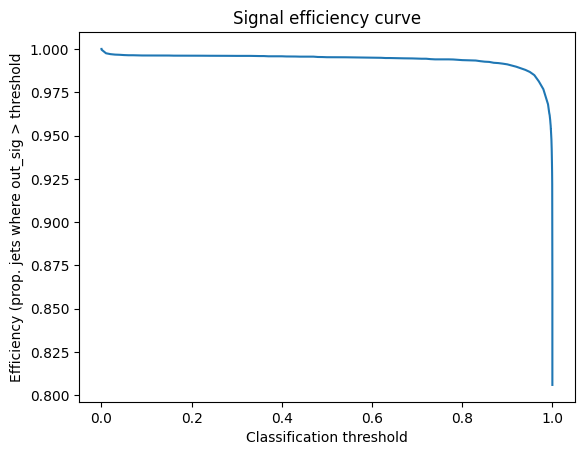

In [20]:
sig_eff_curve = get_eff(sig_probs, thresh)
plt.title("Signal efficiency curve")
plt.xlabel("Classification threshold")
plt.ylabel("Efficiency (prop. jets where out_sig > threshold")
plt.plot(thresh[:-20], sig_eff_curve[:-20], label="Signal");

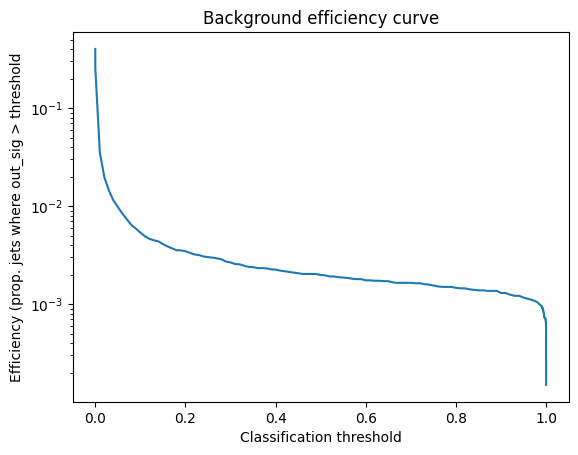

In [21]:
bg_eff_curve = get_eff(bg_probs, thresh)
plt.title("Background efficiency curve")
plt.xlabel("Classification threshold")
plt.ylabel("Efficiency (prop. jets where out_sig > threshold")
plt.yscale("log")
plt.plot(thresh[20:-20], bg_eff_curve[20:-20], label="Background");

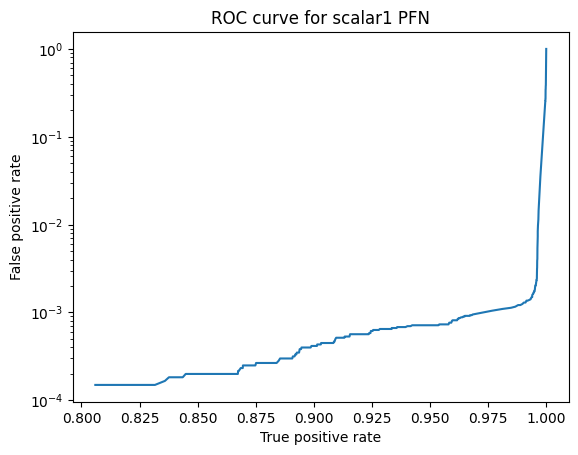

In [22]:
plt.title(f"ROC curve for {task_name} PFN")
plt.plot(sig_eff_curve[:], bg_eff_curve[:])
plt.xlabel("True positive rate")
plt.ylabel("False positive rate")
plt.yscale("log")

In [23]:
def get_thresh(probs, desired_eff):
    return root(lambda x: get_eff(probs, x) - desired_eff, 0.5).x[0]

In [24]:
table = []
working_pts = [0.5, 0.9, 0.99, 0.999]
for desired_eff in working_pts:
    thresh = get_thresh(sig_probs, desired_eff)
    sig_eff = get_eff(sig_probs, thresh)
    inv_bg_eff = 1 / get_eff(bg_probs, thresh)
    table.append([thresh, sig_eff, inv_bg_eff])

In [25]:
# print(tabulate(table, headers=["Thresh", "Sig_eff", "inv bg_eff"]))
print(f"Efficiency analysis table for {task_name} PFN")
print(tabulate(
    table,
    headers=["Classification threshold", r"$\varepsilon_s$", r"$1/\varepsilon_b$"],
    floatfmt=".3f"
))

Efficiency analysis table for scalar1 PFN
  Classification threshold    $\varepsilon_s$    $1/\varepsilon_b$
--------------------------  -----------------  -------------------
                     1.000              0.848             5012.333
                     1.000              0.900             2405.920
                     0.917              0.990              801.973
                    -0.262              1.000                1.000
